In [3]:
import glob
import pandas as pd
import pickle as pk
import numpy as np

import vtils
from vtils import getnormdis

# This path leads to a result of a previous training process. See that of yours 
# by changing this path to the dump path corresponding your training process.
preview_dump = '/home/sensing/caizhijie/0710-falldewideo/control/valid_mid*'

dumplist = glob.glob(preview_dump)
x_tick_gen = range(0, 300, 10)

valids = pd.DataFrame.from_dict({'valids': dumplist})
valids['epoch'] = valids['valids'].apply(lambda x: int(x.split('_')[-3]))
valids['batch'] = valids['valids'].apply(lambda x: int(x.split('_')[-2]))

Text(0.5, 1.0, 'pd')

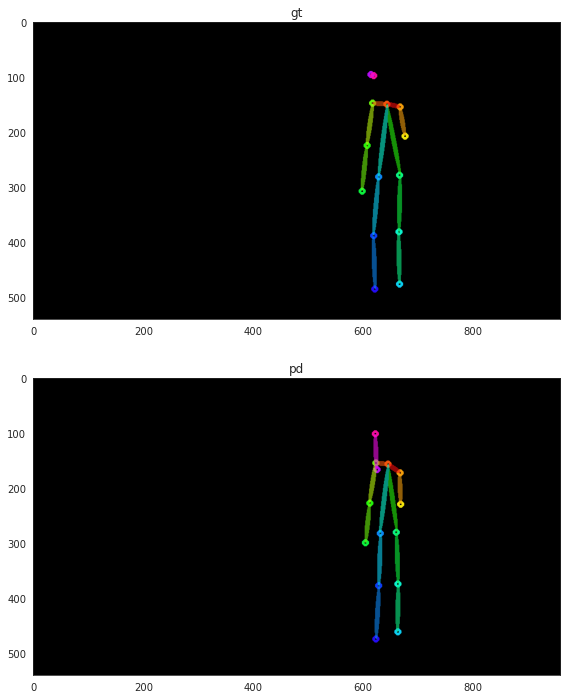

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from vtils import getkpt, pose, ncolors

colors = ncolors(19)[0]
colors[18] = np.array([0, 0, 0])

idx = 2
kptidx = 10
w, h = 64, 36

fig, ax = plt.subplots(2, 1, figsize=(10, 12))
sns.set_style('white')

arr = pk.load(open(valids.iloc[-1]['valids'], 'rb'))
realkpts, fakekpts = getkpt(arr, idx, 0, w, h, False)
canvas = np.zeros((960, 540, 3)).astype(np.uint8)
c0 = pose(canvas, realkpts, colors=colors)
canvas = np.zeros((960, 540, 3)).astype(np.uint8)
c1 = pose(canvas, fakekpts, colors=colors)

ax[0].imshow(c0.transpose((1, 0, 2)))
ax[1].imshow(c1.transpose((1, 0, 2)))
ax[0].set_title('gt')
ax[1].set_title('pd')

In [5]:
allnormacrossepoch = list()

for j in x_tick_gen:

    focus = valids[valids['epoch'] == j].sort_values('batch')

    import tqdm
    import pickle as pk

    allnormdist = list()

    for i in tqdm.trange(len(focus)):
        
        arr = pk.load(open(focus.iloc[i]['valids'], 'rb'))
        normdislist = getnormdis(arr)
        
        allnormdist.extend(normdislist)
        
    allnormacrossepoch.append(allnormdist)

100%|██████████| 111/111 [00:09<00:00, 12.02it/s]


Text(69.0, 0.5, 'PCK@')

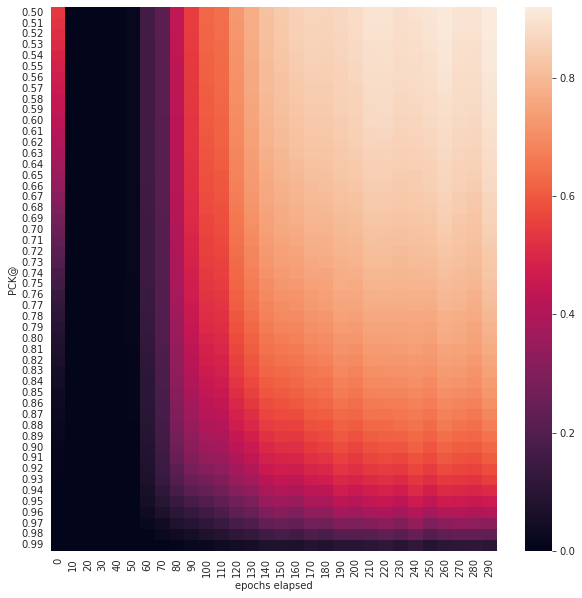

In [6]:
normthres = [(50 + i) / 100 for i in range(50)]
normthresarr = np.expand_dims(np.array(normthres), 1)

pcklist = list()

for epochresult in allnormacrossepoch:
    pck = dict(zip(['%.2f' % _ for _ in normthres], list((np.expand_dims(np.array(epochresult), 0) < (1 - normthresarr)).sum(1) / len(epochresult))))
    
    pcklist.append(np.array(list(pck.values())))
    
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

x_tick = list(x_tick_gen)
y_tick = ['%.2f' % _ for _ in normthres]

df = pd.DataFrame(np.stack(pcklist).transpose(), index=y_tick, columns=x_tick)
sns.heatmap(data=df, square=False)

label_y = ax.get_yticklabels()
plt.setp(label_y, rotation = 360)

ax.set_xlabel('epochs elapsed')
ax.set_ylabel('PCK@')

(-0.03, 1.03)

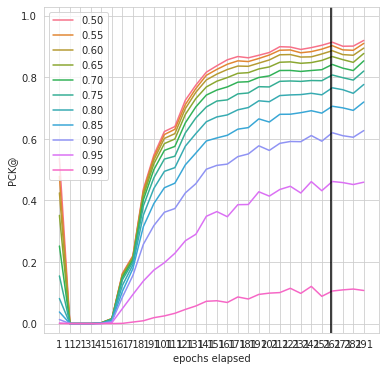

In [7]:
normthres = [0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99]
normthresarr = np.expand_dims(np.array(normthres), 1)

x_tick = [1 + _ for _ in list(x_tick_gen)]
y_tick = ['%.2f' % _ for _ in normthres]

pcklist = list()

for epochresult in allnormacrossepoch:
    pck = dict(zip(['%.2f' % _ for _ in normthres], list((np.expand_dims(np.array(epochresult), 0) < (1 - normthresarr)).sum(1) / len(epochresult))))
    
    pcklist.append(np.array(list(pck.values())))

sns.set_style('whitegrid')
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

df = pd.DataFrame(np.stack(pcklist), columns=y_tick, index=x_tick)
sns.lineplot(data=df, dashes=False)
label_x = ax.get_xticklabels()

ax.set_xlabel('epochs elapsed')
ax.set_ylabel('PCK@')
ax.set_xticks(x_tick)

ax.vlines(260, -1, 2, 'black')

ax.set_ylim(-0.03, 1.03)

In [9]:
df.iloc[-1]

0.50    0.920170
0.55    0.910575
0.60    0.895242
0.65    0.877832
0.70    0.853794
0.75    0.820655
0.80    0.777030
0.85    0.720051
0.90    0.627164
0.95    0.459492
0.99    0.107528
Name: 291, dtype: float64